# Risk Measurement

We will model stock return using random variable to measure and manage financial risk. When the risk is small but it still occurs, this is called a [black swan](https://en.wikipedia.org/wiki/Black_swan_theory). We'll see that:
- Log of daily returns can be approximated with a normal distribution
- Risk can be measured using the cumulative distribution function
- Value at Risk (VaR) measures how much a set of investments might lose with a probability

## Preliminary on Statistics

Daily stock return is a continuous random variable. A discrete random variable, on the other hand, is like the sum of rolling two dices.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [12]:
def roll_two_dices(trial):
    """
    Roll two dices for the given number of times.
    The sum of the two dies is a random variable.
    """
    die = pd.DataFrame([1, 2, 3, 4, 5, 6])
    result = [die.sample(2, replace=True).sum().loc[0] for i in range(trial)]
    return result # contains the realised outcomes

[]

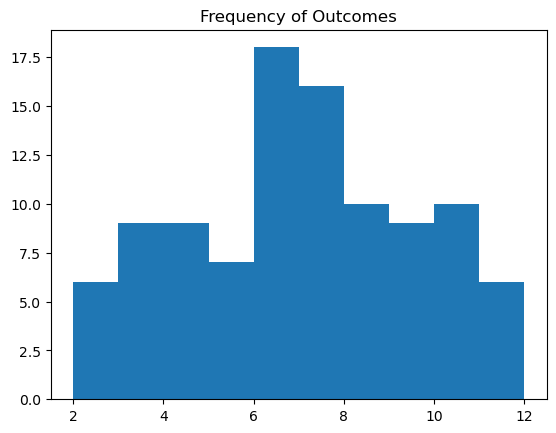

In [15]:
# plot the observed outcomes
rolls100 = roll_two_dices(100)
plt.hist(roll_two_dices(100))
plt.title("Frequency of Outcomes")
plt.plot()

In [21]:
# get the frequency of each outcome
freqs100 = pd.DataFrame(rolls100).value_counts().sort_index()
freqs100

2      2
3      6
4      9
5     12
6     15
7     18
8     13
9     10
10     8
11     6
12     1
Name: count, dtype: int64

<Axes: xlabel='0'>

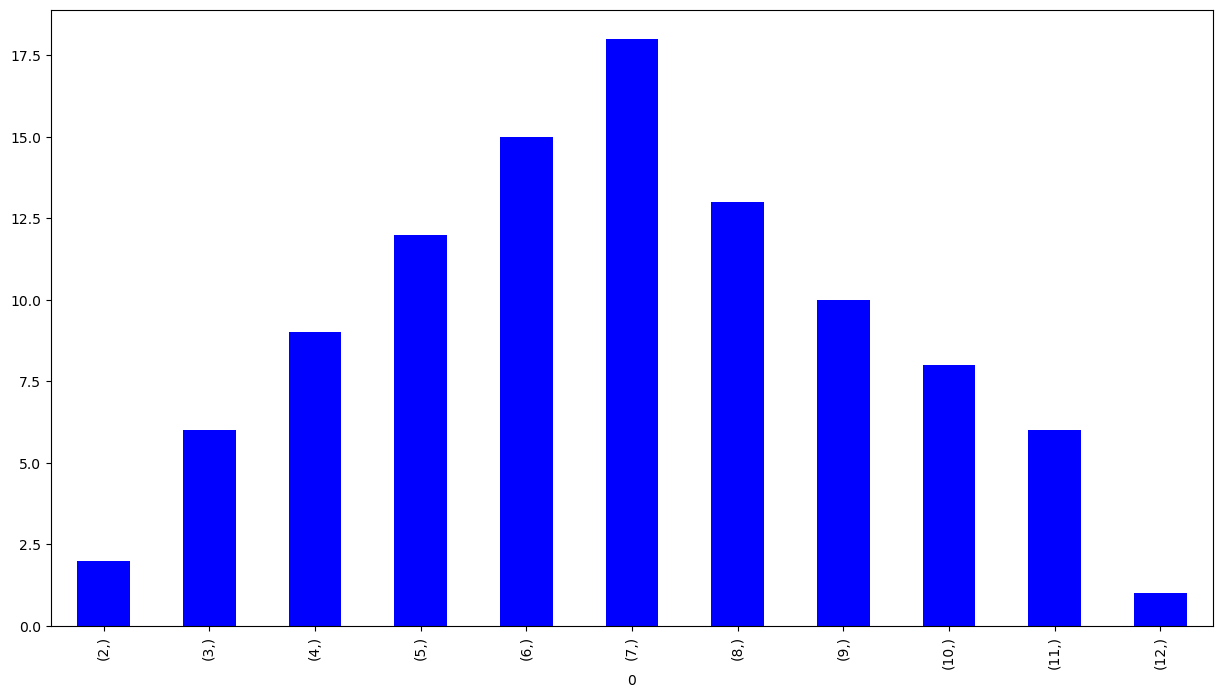

In [22]:
# visualize the frequency in a barchart
freqs100.plot(kind='bar', color='blue', figsize=(15, 8))

[]

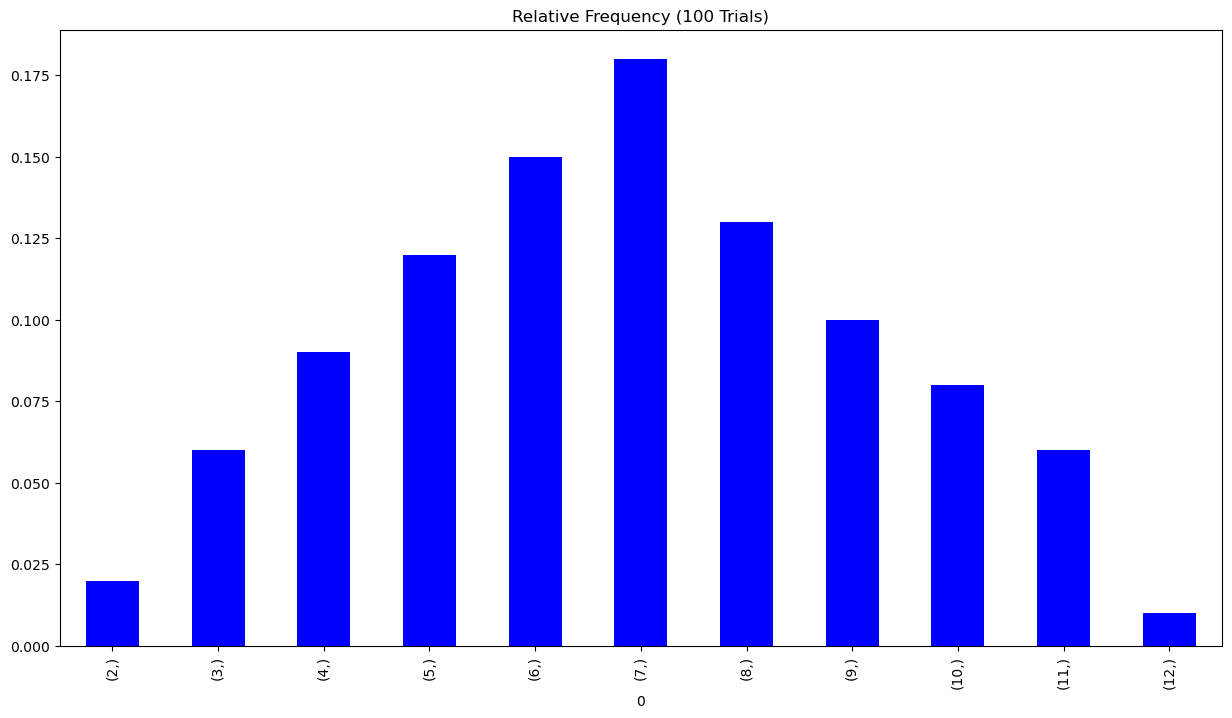

In [39]:
# let's rescale the frequency to use relative frequency: this will help us get the probability distribution
relative_freq = freqs100/100
relative_freq.plot(kind='bar', color='blue', figsize=(15, 8))
plt.title("Relative Frequency (100 Trials)")
plt.plot()

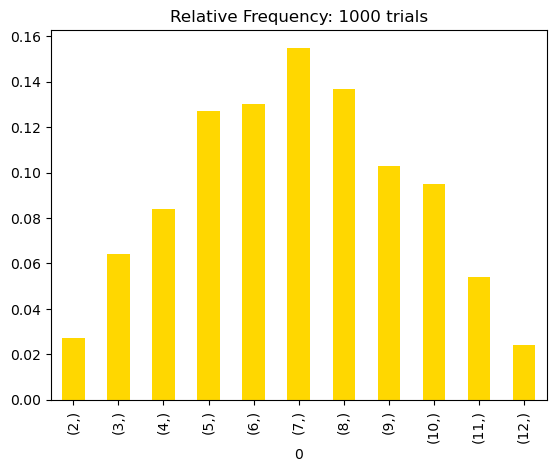

In [45]:
# let's increase the number of trials to 1000: the relative frequency should approximate a normal distribution
freqs1000 = pd.DataFrame(roll_two_dices(1000)).value_counts().sort_index()
(freqs1000/1000).plot(kind='bar', color='gold')
plt.title("Relative Frequency: 1000 trials")
plt.show()

<Axes: >

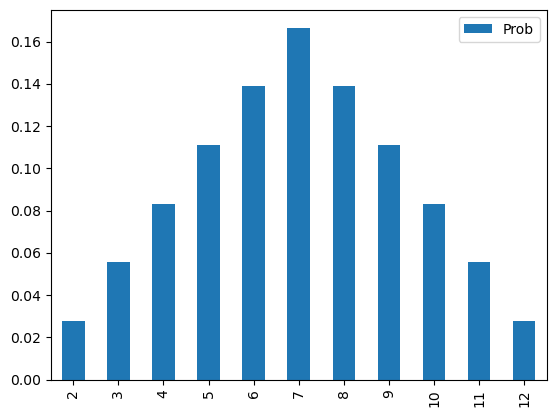

In [47]:
# assume that we have fair dice, which means all faces will be shown with equal probability
# it turns out that the sum_of_dice (which is a random variable) is normally distributed

X_distri = pd.DataFrame(index=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) # all possible outcomes
X_distri['Prob'] = [1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1] # frequency of each outcome
X_distri['Prob'] = X_distri['Prob']/36
X_distri.plot(kind='bar')

In [48]:
# calculate the mean and variance of the distribution
mean = pd.Series(X_distri.index * X_distri['Prob']).sum()
var = pd.Series(((X_distri.index - mean)**2)*X_distri['Prob']).sum()

print(mean, var)

6.999999999999998 5.833333333333333


In [51]:
# compare with the empirical mean and variance of our sample, which will approximate the normal distribution with enough trials
rolls100 = pd.Series(rolls100)
rolls100.mean(), rolls100.var()

(6.86, 5.394343434343434)

## Modeling Stock Returns

Key concepts:
- VaR at 95% corresponds to the 5% percentile of daily return
- If VaR at 95% is -0.03, it means with 5% chance the daily return is worse than 3%

We will use the normal distribution as our model.

In [55]:
from scipy.stats import norm

In [52]:
ms = pd.read_csv('data/microsoft.csv')
ms.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-31,46.730000,47.439999,46.450001,46.450001,42.848763,21552500
1,2015-01-02,46.660000,47.419998,46.540001,46.759998,43.134731,27913900
2,2015-01-05,46.369999,46.730000,46.250000,46.330002,42.738068,39673900
3,2015-01-06,46.380001,46.750000,45.540001,45.650002,42.110783,36447900
4,2015-01-07,45.980000,46.459999,45.490002,46.230000,42.645817,29114100


In [54]:
# look at the distribution of log daily return: it should approximate a normal distribution
ms['LogReturn'] = np.log(ms['Close']).shift(-1) - np.log(ms['Close'])

In [56]:
# estimate the probability distribution function of daily log returns using normal distribution
# the normal distribution is characterized by two parameters: mu and sigma
mu = ms['LogReturn'].mean()
sigma = ms['LogReturn'].std(ddof=1)
density = pd.DataFrame()
density['x'] = np.arange(ms['LogReturn'].min()-0.01, ms['LogReturn'].max()+0.01, 0.001)
density['pdf'] = norm.pdf(density['x'], mu, sigma)

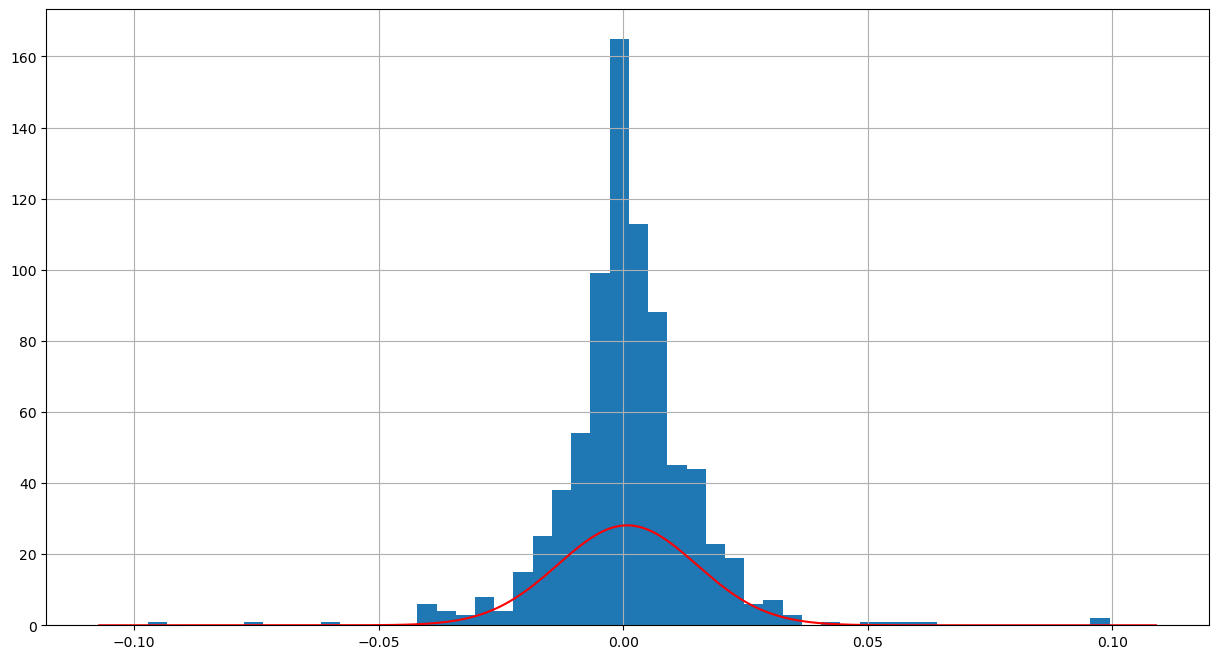

In [57]:
# plot histogram and the fitted normal distribution
ms['LogReturn'].hist(bins=50, figsize=(15, 8))
plt.plot(density['x'], density['pdf'], color='red')
plt.show()

Question:
1. what is the probability that the stock price will drop over 5% in a day?
2. what is the probability that the stock price will drop over 20% in a year?

In [59]:
# the probability that microsoft stock price will drop over 5% in a day
prob_return1 = norm.cdf(-0.05, mu, sigma)
prob_return1

0.00017118482608677817

In [61]:
# the probability that microsoft stock price will drop by 20% in a year
mu_1yr = 220 * mu # one year has 220 trading days
sigma_1yr = 220**0.5 * sigma # assume all daily returns are independent
prob_return220 = norm.cdf(-0.2, mu_1yr, sigma_1yr)
prob_return220

0.03535237727490905

In [62]:
# single day value at risk: with 5% chance that the daily return is worse than this
VaR = norm.ppf(0.05, mu, sigma)
VaR

-0.022523362407065